## 第4章 線形識別モデル

- http://www.chokkan.org/publication/survey/prml_chapter4_discriminative_slides.pdf
- http://aidiary.hatenablog.com/entry/20100430/1272590402
- http://gihyo.jp/dev/serial/01/machine-learning/0015
- http://www.slideshare.net/pecorarista/prml04
- http://bin.t.u-tokyo.ac.jp/prml2009/ppt/PRML04.ppt

がわかりやすかった．

gihyoの連載の冒頭付近を引用すると以下で，とてもわかりやすい．

> 回帰問題ではデータから関数を作りましたから，未知のデータに対してもその関数値を予測することができました。同じように考えれば，データを入力したらそのカテゴリーが出力されるような関数を作ることができればよさそうです。そのような関数は「分類関数」という単純な名前が付いています。

> 二値分類において，例えばメールのスパム分類の場合の「スパム」と「非スパム」のように，分類関数は2種類の「値」をとりえますが，関数という以上はそれは数値である必要があります。そこで「スパム」に＋1を，「非スパム」に－1を，というように適当な数値にそれぞれ割り当てます。

> 当然，「なんかスパムが正の値で，非スパムが負の値ってやだなあ。逆じゃあダメなの？」とか「±1じゃあなくて0と1のほうがよくない？」といった疑問がわくことでしょう。

> どのクラスをどの数値に割り当てるかは便宜的なもので，必然性はありませんから，割り当てを入れ替えても全くかまいません。そうしたところで符号が反転した分類関数が求まるだけですしね。

> 一方，割り当てる数値は問題の解き方やモデルにあわせて都合がよいものを使います。ここではこの後紹介するモデルにとって±1が都合がよいのでそれを選んでいますが，モデルによっては1と0などを割り当てることもあります。

> さて，こうしてそれぞれのデータに対して±1の値をとる関数を作ればいいというところまできました。

> 関数を作るということなら，これを回帰問題として解くこともできそうな気がしますが，残念ながらそう単純にはいきません。というのも，回帰によって得られる関数は当然ながら±1以外の値も取り得るからです。

> それだけのことなら「近い方の値に寄せる」というシンプルな解決方法はあります。しかし，正解ラベルが＋1のデータ点では関数が値－0.5をとるより値＋10をとる方が分類関数としては望ましいわけですが，回帰の二乗誤差では－0.5の方が誤差が少ないということになってしまいます。これではモデルが期待通りに学習されるとは到底思えません。

> つまり，分類問題のためのモデルがやはり別に必要ということがわかります。

#### 章の構成
線形識別モデルには3つの方法があって，
- 4.1 識別関数モデル
   - 4.1.1 2クラス
   - 4.1.2 多クラス
   - 4.1.3 最小二乗による分類
   - 4.1.4 フィッシャーの線形判別
   - 4.1.7 パーセプトロン
- 4.2 確率的生成モデル
   - 2クラス
      - ロジスティックシグモイド関数
   - 多クラス
      - ソフトマックス関数
- 4.3 確率的識別モデル
   - 4.3.1 固定限定関数
   - 4.3.2 ロジスティック回帰
   - 4.3.3 IRLS or 反復再重み付け最小二乗
   - 4.3.4 プロピット回帰
   - 4.5 ベイズロジスティック回帰
      - 4.5.1 ラプラス近似

確率的生成モデルと確率的識別モデルの違いは，
- 生成モデルは，条件付き確率分布 $p(x|C_k)$と事前確率 $p(C_k)$ をモデル化してベイズの定理で事後確率を計算する
- 識別モデルは，条件付き確率分布 $p(C_k|x)$ を直接モデル化
ということらしい． by http://www.chokkan.org/publication/survey/prml_chapter4_discriminative_slides.pdf

勉強したら良いことは

1. 図4.4+4.5 最小二乗法だとうまく行かないが，ロジスティック回帰モデルだとうまく行く
2. 図4.6　最小二乗の良い感じにしたフィッシャーの線形判別を使うとちょっと良くなる
3. 図4.7　パーセプトロンを使うと線形分離可能であれば確実に解が求まる
4. 図4.12　非線形変換をすると，簡単に分離できる例

くらいか？

#### 図4.4と図4.5から学べること

これらの図は最小二乗法よりもロジスティック回帰モデルの方がよさ気であることを言っている．理由は以下．

1. 最小二乗法による識別では，ノイズに引っ張られてしまう傾向があるから．
1. 最小二乗法による識別では，多クラスでうまく行かないから．

これを再現してみる．

簡単に，二次のデータがいっぱいあって，2つにクラスタリングできるとする．

$$
\begin{align}
x_1 &= \begin{pmatrix} 5\\ 5\end{pmatrix}\\
x_2 &= \begin{pmatrix} 5\\ 4\end{pmatrix}\\
x_3 &= \begin{pmatrix} -1\\ 2\end{pmatrix}
\end{align}
$$

みたいなデータと，それに対応する

$$
\begin{align}
t_1 &= \begin{pmatrix} 1\\ 0\end{pmatrix}\\
t_2 &= \begin{pmatrix} 1\\ 0\end{pmatrix}\\
t_3 &= \begin{pmatrix} 0\\ 1\end{pmatrix}
\end{align}
$$

みたいなラベルがあるとする．

このとき，各クラスごとに，線形モデル
$$
y_k (x) = w_k^T x + w_0
$$
があるので，まとめて，
$$
\begin{align}
&\begin{pmatrix}y_1\\ y_2\end{pmatrix} =
\begin{pmatrix}
w_{10} & w_1^T\\
w_{20} & w_2^T
\end{pmatrix}
\begin{pmatrix}
1\\
x
\end{pmatrix}\\
\Leftrightarrow & \begin{pmatrix}y_1\\ y_2\end{pmatrix} =
\begin{pmatrix}
w_{10} & w_{20}\\
w_1 & w_2
\end{pmatrix}
\begin{pmatrix}
1\\
x
\end{pmatrix}\\
\Leftrightarrow & y = \widetilde{\textbf{W}}^{T} \tilde{x}
\end{align}
$$
ここで，
$$
\widetilde{\textbf{X}} = \begin{pmatrix}
\tilde{x}_1^{T}\\
\tilde{x}_2^{T}\\
\tilde{x}_3^{T}
\end{pmatrix} = \begin{pmatrix}
1 & 5 & 5\\
1 & 5 & 4\\
1 & -1 & 2
\end{pmatrix}
$$
$$
\textbf{T} = \begin{pmatrix}
t_1^{T}\\
t_2^{T}\\
t_3^{T}
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
1 & 0\\
0 & 1
\end{pmatrix}
$$
とすると，二乗和誤差関数は
$$
\frac{1}{2}\mathrm{Tr}\left\{
\left(
\widetilde{\textbf{X}}
\widetilde{\textbf{W}} - \textbf{T}
\right)^{T}
\left(
\widetilde{\textbf{X}}
\widetilde{\textbf{W}} - \textbf{T}
\right)
\right\}
$$
と書けるらしい．
微分して最適化すると
$$
\widetilde{\textbf{W}} = 
\left(
\widetilde{\textbf{X}}^{T}
\widetilde{\textbf{X}}
\right)^{-1}
\widetilde{\textbf{X}}^{T}
\textbf{T}
$$
となる．

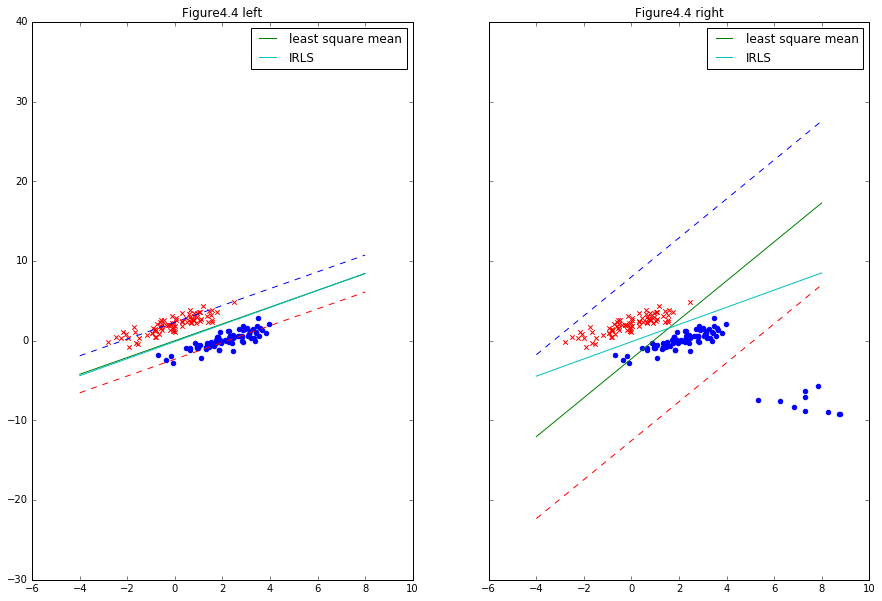

In [15]:
# %matplotlib inline
import matplotlib.pyplot
import numpy as np
import random

def calcW(red, blue):
    r_num = red.shape[0]
    b_num = blue.shape[0]
    X_tilde = np.hstack((np.ones([r_num + b_num, 1]),
                         np.vstack((red, blue))))
    T_tilde = []
    for n, l in zip([r_num, b_num], [[1.0, 0.0], [0.0, 1.0]]):
        for i in range(n):
            T_tilde.append(np.array(l))
    T_tilde = np.array(T_tilde)
    W_tilde = np.linalg.inv(X_tilde.T.dot(X_tilde)).dot(X_tilde.T).dot(T_tilde)
    return W_tilde

def calcW_IRLS(red, blue):
    r_num = red.shape[0]
    b_num = blue.shape[0]
    N = r_num + b_num
    PHI = np.hstack((np.ones([N, 1]),
                     np.vstack((red, blue))))
    t = []
    for n, l in zip([r_num, b_num], [1.0, 0.0]):
        for i in range(n):
            t.append(l)
    t = np.array(t)
    w = np.array([0.0, 0.0, 0.0]) # initial value
    while True:
        # calc R and y
        R = np.zeros([N, N])
        y = []
        for n in range(N):
            y_n = 1.0 / (1 + np.exp(- np.dot(w, PHI[n, ])))
            R[n, n] = y_n * (1.0 - y_n)
            y.append(y_n)
        # calc H
        H = np.dot(PHI.T, np.dot(R, PHI))
        # update w
        w_new = w - np.dot(np.linalg.inv(H), np.dot(PHI.T, y - t))
        # check convergence
        if np.linalg.norm(w_new - w) <  np.linalg.norm(w) * 0.1:
            break
        w = w_new
    return w

def my_plot(red, blue, ax, title):
    x_line = np.linspace(-4, 8, 1000)
    W_tilde = calcW(red, blue)
    w_IRLS = calcW_IRLS(red, blue)
    # linear model for red data
    ax.plot(x_line,
            [-1 * (W_tilde[0][0] * 1 + W_tilde[1][0] * x) / W_tilde[2][0] for x in x_line],
            'r--')
    # linear model for blue data
    ax.plot(x_line,
            [-1 * (W_tilde[0][1] * 1 + W_tilde[1][1] * x) / W_tilde[2][1] for x in x_line],
            'b--')
    # mean of the linear models ?
    ax.plot(x_line,
            [-1 * ((W_tilde[0][0] - W_tilde[0][1]) * 1 + (W_tilde[1][0] - W_tilde[1][1]) * x) / (W_tilde[2][0] - W_tilde[2][1]) for x in x_line],
            'g-',
            label="least square mean")
    ax.plot(x_line,
            [-1 * (w_IRLS[0] + w_IRLS[1] * x) / w_IRLS[2] for x in x_line],
            'c-',
            label="IRLS")
    ax.scatter(red[:, 0], red[:, 1], color='r', marker='x')
    ax.scatter(blue[:, 0], blue[:, 1], color='b', marker='o')
    ax.set_title(title)
    ax.legend(loc=0)

if __name__ == "__main__":
    # sumple data
    ## setting
    mu_red  = [0.0, 2.0]
    mu_blue = [2.0, 0.0]
    mu_out  = [8.0, -8.0]
    cov = [[1.2, 1.0],
           [1.0, 1.2]]
    cov_out = [[1.0, 0.0],
               [0.0, 1.0]]
    data_num = 80
    out_num  = 10
    ## generate
    np.random.seed(0)
    red  = np.random.multivariate_normal(mu_red,  cov, data_num)
    blue = np.random.multivariate_normal(mu_blue, cov, data_num)
    blue_out = np.random.multivariate_normal(mu_out, cov_out, out_num)
    blue_new = np.vstack((blue, blue_out))

    # figure
    matplotlib.pyplot.rcParams['figure.figsize'] = (15.0, 10.0)
    f, (ax) = matplotlib.pyplot.subplots(1, 2, sharex=True, sharey=True)

    # plot
    my_plot(red, blue, ax[0], "Figure4.4 left")
    my_plot(red, blue_new, ax[1], "Figure4.4 right")
    matplotlib.pyplot.show()

上記のように，最小二乗法によって$\textbf{W}$を求めても，外れ値に引っ張られてしまう．
ロジスティック回帰を考えるとうまく行くらしい．

まずは，2クラスで，上と同じ状況を考える．
事後確率は
$$
p(C_1 | \phi(x)) = \sigma (w^{T} \phi(x))\\
p(C_2 | \phi(x)) = 1 - p(C_1 | \phi(x))
$$
と書けるらしく，尤度関数は
$$
p(\textbf{T} | w) = \Pi_{n=1}^{N} p(C_1 | \phi_n(x))^{t_n} \left\{1 - p(C_1 | \phi_n(x))\right\}^{1- t_n}
$$
となる．ただし，上の例と違って，$t_n \in \left\{0, 1\right\}$．

なので，誤差関数を
$$
\begin{align}
E(w) &= - \mathrm{ln} p(\textbf{T} | w) = - \sum_{n=1}^{N} \left\{t_n \mathrm{ln} p(C_1 | \phi_n(x)) + (1 - t_n) \mathrm{ln} (1 - p(C_1 | \phi_n(x)))\right\}\\
&= - \sum_{n=1}^{N} \left\{t_n \mathrm{ln} \sigma (w^{T} \phi_n(x)) + (1 - t_n) \mathrm{ln} (1 - \sigma (w^{T} \phi_n(x)))\right\}
\end{align}
$$
と置くと，置換微分やロジスティックシグモイドの微分の式を駆使しつつ，ちょっと頑張って微分すると
$$
\begin{align}
\nabla E(w) &= \sum_{n=1}^{N} \left(\sigma (w^{T} \phi_n(x)) - t_n \right) \phi_n(x)\\
&= \left(\sigma (w^{T} \begin{pmatrix} 1\\ 5\\ 5\end{pmatrix}) - 1 \right) \begin{pmatrix} 1\\ 5\\ 5\end{pmatrix} + \left(\sigma (w^{T} \begin{pmatrix} 1\\ 5\\ 4\end{pmatrix}) - 1 \right) \begin{pmatrix} 1\\ 5\\ 4\end{pmatrix} + \left(\sigma (w^{T} \begin{pmatrix} 1\\ -1\\ 2\end{pmatrix}) - 0 \right) \begin{pmatrix} 1\\ -1\\ 2\end{pmatrix}\\
&= \left(y_1 - t_1 \right) \begin{pmatrix} 1\\ 5\\ 4\end{pmatrix} + \left(y_2 - t_2 \right) \begin{pmatrix} 1\\ 5\\ 4\end{pmatrix} + \left(y_3 - t_3 \right) \begin{pmatrix} 1\\ -1\\ 2\end{pmatrix}\\
&= \begin{pmatrix}
1 & 1 & 1\\
5 & 5 & -1\\
5 & 4 & 2
\end{pmatrix}
\begin{pmatrix}
y_1 - t_1\\
y_2 - t_2\\
y_3 - t_3
\end{pmatrix}\\
&= \begin{pmatrix}
1 & 1 & 1\\
5 & 5 & -1\\
5 & 4 & 2
\end{pmatrix} \left(\textbf{y} - \textbf{t}\right)\\
&= \textbf{$\phi$}^{T} \left(\textbf{y} - \textbf{t}\right)
\end{align}
$$
となる．また，
$$
\begin{align}
\textbf{H} &= \nabla \nabla E(w) = \sum_{n=1}^{N} \sigma (w^{T} \phi_n(x)) (1- \sigma (w^{T} \phi_n(x))) \phi_n (x) \phi_n (x)^{T}\\
&=
\textbf{$\phi$}^{T}
\begin{pmatrix}
y_1 (1-y_1) & 0 & 0\\
0 & y_2 (1-y_2) & 0\\
0 & 0 & y_3 (1-y_3)
\end{pmatrix}
\begin{pmatrix}
\phi_1^{T}\\
\phi_2^{T}\\
\phi_3^{T}
\end{pmatrix}\\
&= 
\textbf{$\phi$}^{T}
\textbf{R}
\textbf{$\phi$}
\end{align}
$$
となる．

$\textbf{R}$は$w$に依存しているので，二回微分が定数ではなく，誤差関数が二次ではないことが分かる．
ニュートンラプソン法に基づく最適化によって
$$
w^{\mbox{new}} = w^{\mbox{old}} - \textbf{H}^{-1} \nabla E(w)
$$
とかけるので，最適化ができる．

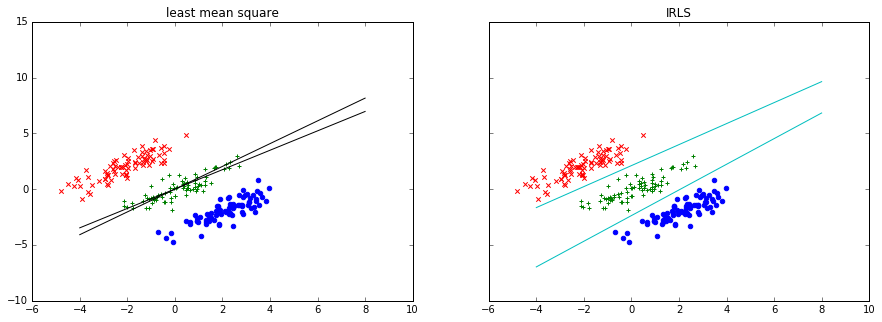

In [13]:
# %matplotlib inline
import matplotlib.pyplot
import numpy as np
import random

def calcW(red, blue, green):
    r_num = red.shape[0]
    b_num = blue.shape[0]
    g_num = green.shape[0]
    X_tilde = np.hstack((np.ones([r_num + b_num + g_num, 1]),
                         np.vstack((red, blue, green))))
    T_tilde = []
    for n, l in zip([r_num, b_num, g_num], np.identity(3)):
        for i in range(n):
            T_tilde.append(l)
    T_tilde = np.array(T_tilde)

    W_tilde = np.linalg.inv(X_tilde.T.dot(X_tilde)).dot(X_tilde.T).dot(T_tilde)
    return W_tilde

def calcW_IRLS(red, blue, green):
    r_num = red.shape[0]
    b_num = blue.shape[0]
    g_num = green.shape[0]
    N = r_num + b_num + g_num
    PHI = np.hstack((np.ones([N, 1]),
                     np.vstack((red, blue, green))))
    T = []
    for n, l in zip([r_num, b_num, g_num], np.identity(3)):
        for i in range(n):
            T.append(l)
    T = np.array(T)
    M = 3
    K = 3
    W = np.zeros((M, K))
    while True:
        # eq. 4.104
        Y = np.zeros((N, K))
        for n in range(N):
            sum = 0.0
            for k in range(K):
                sum += np.exp(np.dot(W[:, k], PHI[n, :]))
            for k in range(K):
                Y[n, k] = np.exp(np.dot(W[:, k], PHI[n, :])) / sum
        # calc H
        I = np.identity(K)
        H = np.zeros((K*K, M, M))
        for j in range(K):
            for k in range(K):
                # eq. 4.110
                for n in range(N):
                    sum = Y[n, k] * (I[k, j] - Y[n, j])
                    H[k+j*K] += sum * np.matrix(PHI)[n].reshape(M, 1) * np.matrix(PHI)[n].reshape(1, M)
        # update W
        W_new = np.zeros((M, K))
        for i in range(K):
            temp = np.dot(PHI.T, Y[:, i] - T[:, i])
            W_new[:, i] = W[:, i] - np.dot(np.linalg.inv(H[i+i*K]), temp)
        # check convergence
        if np.linalg.norm(W_new - W) <  np.linalg.norm(W) * 0.1:
            break
        W = W_new
    return W


def my_plot(red, blue, green, axes):
    W_tilde = calcW(red, blue, green)
    W_IRLS  = calcW_IRLS(red, blue, green)
    x_line = np.linspace(-4, 8, 1000)
    # mean of the linear models ?
    axes[0].plot(x_line,
                 [-1 * ((W_tilde[0][0] - W_tilde[0][1]) * 1 + (W_tilde[1][0] - W_tilde[1][1]) * x) / (W_tilde[2][0] - W_tilde[2][1]) for x in x_line],
                 'k-')
    axes[0].plot(x_line,
                 [-1 * ((W_tilde[0][2] - W_tilde[0][1]) * 1 + (W_tilde[1][2] - W_tilde[1][1]) * x) / (W_tilde[2][2] - W_tilde[2][1]) for x in x_line],
                 'k-')
    axes[1].plot(x_line,
                 [-1 * ((W_IRLS[0][0] - W_IRLS[0][2]) * 1 + (W_IRLS[1][0] - W_IRLS[1][2]) * x) / (W_IRLS[2][0] - W_IRLS[2][2]) for x in x_line],
                 'c-')
    axes[1].plot(x_line,
                 [-1 * ((W_IRLS[0][2] - W_IRLS[0][1]) * 1 + (W_IRLS[1][2] - W_IRLS[1][1]) * x) / (W_IRLS[2][2] - W_IRLS[2][1]) for x in x_line],
                 'c-')
    for ax, title in zip(axes, ["least mean square", "IRLS"]):
        ax.scatter(red[:, 0], red[:, 1], color='r', marker='x')
        ax.scatter(blue[:, 0], blue[:, 1], color='b', marker='o')
        ax.scatter(green[:, 0], green[:, 1], color='g', marker='+')
        ax.set_title(title)

if __name__ == "__main__":
    # sumple data
    ## setting
    mu_red   = [-2.0,  2.0]
    mu_blue  = [ 2.0, -2.0]
    mu_green = [ 0.0,  0.0]
    cov = [[1.2, 1.0],
           [1.0, 1.2]]
    data_num = 80
    ## generate
    np.random.seed(0)
    red   = np.random.multivariate_normal(mu_red,   cov, data_num)
    blue  = np.random.multivariate_normal(mu_blue,  cov, data_num)
    green = np.random.multivariate_normal(mu_green, cov, data_num)

    # figure
    matplotlib.pyplot.rcParams['figure.figsize'] = (15.0, 5.0)
    f, (ax) = matplotlib.pyplot.subplots(1, 2, sharex=True, sharey=True)

    # plot
    my_plot(red, blue, green, ax)
    matplotlib.pyplot.show()

多クラスのときに適用すると，上のような感じ．